This is my fourth Ubiquant competition notebook. Please also see my other three notebooks.

- ["Ubiquant Target EDA PCA Magic"](https://www.kaggle.com/marketneutral/ubiquant-target-eda-pca-magic)
- ["Stacking & Feature Importance"](https://www.kaggle.com/marketneutral/stacking-feature-importance)
- ["Ubiquant Feature Exploration"](https://www.kaggle.com/marketneutral/ubiquant-feature-exploration)

# Updated!

## Version Notes

- (1) Version 2 released Feb 16, 2022
- (2) Version 3 released Feb 28, 2022
    - added single target baseline
    - added comparision of predictions between single target and dual target


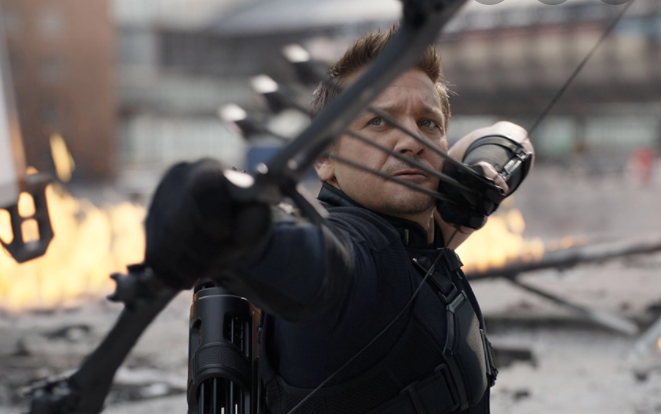

# Why Multi-Target?

One thing that I thought was great in the Jane Street competition is that the competition data included five targets, even though the competition was scored against a single target. In that competition, some simple EDA shows that the targets were forward returns at different time horizons. High scoring notebooks (and the first place solution) trained against all 5 targets. It's likely that for financial time series the multi-target training makes a model more robust. The Ubiquant competition only has one target, but perhaps we can manufacture a second target, further out in time, and train against both. That's the goal of this notebook.

The challenge with doing this is that the targets do not exist for all investment id's for all time id's. I use a reconstituted target from [this notebook](https://www.kaggle.com/marketneutral/ubiquant-target-eda-pca-magic).

**This kind of robust NN model could be good to ensemble with more aggressively fitted models.**

In [ ]:
import gc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import missingno as msno
from scipy.stats import zscore

import torch
import torch.nn as nn
import torch.nn.functional as F

from fastai.tabular.data import TabularDataLoaders
from fastai.tabular.learner import TabularLearner
from fastai.callback.schedule import fit_one_cycle, lr_find  # this is monkey patched 

plt.rcParams['figure.figsize'] = (16, 5)

In [ ]:
import fastai; fastai.__version__

# Load Data

In [ ]:
%%time
train = (pd.read_parquet('../input/ubiquant-parquet/train_low_mem.parquet')
         .sort_values(['investment_id', 'time_id']));

In [ ]:
all_columns = train.columns
features = all_columns[train.columns.str.contains('f_')]

The competition data is provided in _long_ format with respect to the `time_id`, `investment_id`, and `target` values. We want to rotate this data to wide format which makes a data matrix of target values, `time_id` $\times$ `investment_id`

In [ ]:
targets_wide = (
    train
    .filter([
        'time_id',
        'investment_id',
        'target'])
    .set_index(['time_id', 'investment_id'])
    .unstack()
    .droplevel(0, axis=1))

targets_wide.shape

However, when we do this, we see that we do not have all targets for all times and all investment ids.|

In [ ]:
(msno.matrix(
    targets_wide.sample(n=250, axis=1),
    figsize=(16, 5),
    width_ratios=(20,1),
    fontsize=10,
    labels=None)
      .set_title('Data Completeness; Targets (250 samples) vs Time'));

You an see that when you rotate the targets into a time_id by investment_id DataFrame that there are substantial missing values. We have over 27% missing values.

In [ ]:
targets_wide.isnull().sum().sum() / targets_wide.size

In [ ]:
(targets_wide
 .isnull()
 .sum(axis=0)
 .max(),

(targets_wide
 .isnull()
 .sum(axis=0) > 1_000
).sum())

We have 1209 unique time_id's in the data. I am going to remove investmen_id's where more than 1,000 days are missing. Then I used the LGBMInputer by [@analokmaus](https://www.kaggle.com/analokamus) to fill in the remaining misssing targets. This takes a little over 2 hours on a Kaggle instance, so I saved the output as [a Dataset](https://www.kaggle.com/marketneutral/ubiquant-lgbm-imputed-targets). I am reading in that dataset here.

In [ ]:
targets_wide = (
    targets_wide
    .iloc[:, list(~(targets_wide.isnull().sum(axis=0) > 1_000))])

targets_wide.shape

In [ ]:
reconst = pd.read_csv('../input/ubiquant-lgbm-imputed-targets/target_lgb_filled.csv', index_col=0)
reconst.shape

# Make Second Target

To create the second target, I am looking for the cumulative "return" of each stock from sample time to the end of the target `time_id` + 1 (i.e., the next time_id). I am making some assumptions here...first is that the targets are additive over time. This is not such a crazy assumption... if they are like log returns then they are additive. I then rescale (zscore) the second target across the time_id so that it has the same influence in the loss function as the first target.

Visually, through time and across `investment_id`, the two targets look like this

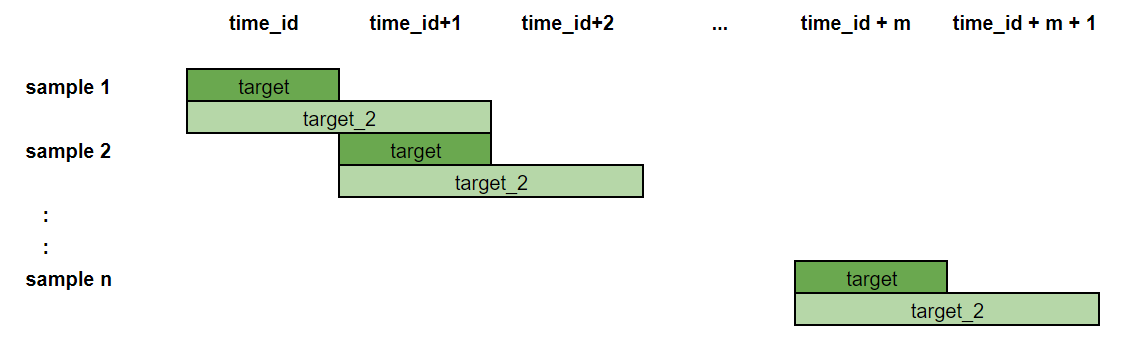

In [ ]:
reconst.index = targets_wide.index
reconst.columns = targets_wide.columns
target_2 = (reconst + reconst.shift(-1)).apply(zscore, axis=1).dropna()
target_2 = target_2.stack().to_frame().rename(columns = {0: 'target_2'})

In [ ]:
train = (
    train
    .set_index(['time_id', 'investment_id'])
    .assign(target_2 = target_2)
)

In [ ]:
gc.collect()

In [ ]:
gc.collect()

In [ ]:
train.head()

As you would expect, these targets are correlated since target two overlaps in time with the first target. 

In [ ]:
fig, ax = plt.subplots(figsize=(9, 9))

(train
 .sample(frac=0.1)
 .plot
 .scatter(x='target',
          y='target_2',
          alpha=0.10,
          title='Competition Target vs Target 2',
          ax=ax));

ax.axvline(0, c='salmon');
ax.axhline(0, c='salmon');
plt.xlim([-10, 10])
plt.ylim([-10, 10])
ax.plot(
    [0, 1], [0, 1],
    transform=ax.transAxes,
    c='salmon',
    linestyle='--'
);

# PyTorch Model

Simple model; I have not done any architecture search or tuning.

In [ ]:
single_target_name = 'target'

dual_target_names = [
    'target',
    'target_2'
]

feature_names = list(train.columns[train.columns.str.contains('f_')])

In [ ]:
# MSE loss; note the `.mean()` at the end to average the loss against each target
# One idea is to try .max() which would be like a robust loss function
def loss_func(y_predicted, y_target):
    return ((y_predicted - y_target)**2).mean()

# for validation we only care about the real target
def valid_func(y_predicted, y_target):
    return (((y_predicted - y_target)**2)[:, 0].mean())

In [ ]:
class Model(nn.Module):
    def __init__(self, num_features, num_targets):
        super().__init__()

        dropouts = [0.10, 0.10, 0.10, 0.10]
        hidden_size = [512, 256, 128]
        
        layers = [nn.BatchNorm1d(num_features)]
        in_size = num_features

        for i in range(len(hidden_size)):
            out_size = hidden_size[i]
            layers.append(nn.Dropout(dropouts[i]))
            layers.append(nn.Linear(in_size, out_size))
            layers.append(nn.BatchNorm1d(out_size))
            layers.append(nn.SiLU())  # SiLU aka swish
            in_size = out_size

        layers.append(nn.Dropout(dropouts[-1]))
        layers.append(nn.Linear(in_size, num_targets))
        
        self.model = torch.nn.Sequential(*layers)

    def forward(self, cat, cont):
        # fastai tabular passes categorical and continuous features separately
        x = self.model(cont)
        return x

I get OOM on the Kaggle instance if I don't cut down the train size.

In [ ]:
train = (train
         .iloc[-1_000_000:, :]
         .dropna()
         .reset_index()
         .sort_values('time_id')
         .reset_index(drop=True))

gc.collect()

In [ ]:
gc.collect()

In [ ]:
NUM_FEATURES = len(feature_names)
BATCH_SIZE = 2**16
EPOCHS = 30

## Baseline: Single Target

In [ ]:
NUM_TARGETS = len(single_target_name)

n_samples = len(train)
split_idx = int(n_samples*0.70)
val_idxs = range(split_idx, n_samples)

dls = TabularDataLoaders.from_df(
    train,
    cont_names=list(feature_names),
    y_names=single_target_name,
    bs=BATCH_SIZE,
    valid_idx=val_idxs
)

In [ ]:
dls.show_batch()

In [ ]:
gc.collect()

In [ ]:
model = Model(
    num_features=NUM_FEATURES,
    num_targets=NUM_TARGETS
)

learner = TabularLearner(
    dls,
    model=model,
    loss_func=loss_func,
    metrics=[valid_func]
)

gc.collect()

learner.fit_one_cycle(EPOCHS)

In [ ]:
gc.collect()

In [ ]:
single_preds = (
    learner.model.to('cpu')(torch.tensor([]), torch.tensor(train[feature_names].values[-50_000:, :], dtype=torch.float))
    .detach()
    .cpu()
    .numpy()
    [:, 0]
)

In [ ]:
gc.collect()

## Two Target Model

In [ ]:
NUM_TARGETS = len(dual_target_names)

n_samples = len(train)
split_idx = int(n_samples*0.70)
val_idxs = range(split_idx, n_samples)

dls = TabularDataLoaders.from_df(
    train,
    cont_names=list(feature_names),
    y_names=dual_target_names,
    bs=BATCH_SIZE,
    valid_idx=val_idxs
)

In [ ]:
model = Model(
    num_features=NUM_FEATURES,
    num_targets=NUM_TARGETS
)

learner = TabularLearner(
    dls,
    model=model,
    loss_func=loss_func,
    metrics=[valid_func]
)

gc.collect()

learner.fit_one_cycle(EPOCHS)


In [ ]:
dual_preds = (
    learner.model.to('cpu')(torch.tensor([]), torch.tensor(train[feature_names].values[-50_000:, :], dtype=torch.float))
    .detach()
    .cpu()
    .numpy()
    [:, 0]
)

In [ ]:
fig, ax = plt.subplots(figsize=(9, 9))

plt.scatter(single_preds, dual_preds, alpha=0.2)
plt.title('Single Target Predictions vs Dual Target Predictions')
plt.xlabel('Prediction from Single Target Model')
plt.ylabel('Preidction from Dual Target Model')
ax.axvline(0, c='salmon');
ax.axhline(0, c='salmon');
plt.xlim([-2, 2])
plt.ylim([-2, 2])
ax.plot(
    [0, 1], [0, 1],
    transform=ax.transAxes,
    c='salmon',
    linestyle='--'
);

The two models have very similiar validation scores. However when we look at a sample of the predictions from each model, we see that they appear very different. This implies that the multi-target model is finding some aspects that the single target is not and would make a good blending candidate with with a single target model.

# Predict with Dual Target Model

In [ ]:
inference_model = learner.model
inference_model.to('cpu')
inference_model.eval()

In [ ]:
%%time

import ubiquant

env = ubiquant.make_env()   # initialize the environment
iter_test = env.iter_test()    # an iterator which loops over the test set and sample submission

for (test_df, sample_prediction_df) in iter_test:
    
    # initialize columns
    test_df['target']  = 0
    
    X_test = test_df.loc[:, feature_names].values
    
    pred_vector = (
        inference_model(torch.tensor([]), torch.tensor(X_test, dtype=torch.float))
             .detach()
             .cpu()
             .numpy()
        )
    
    # we want the competition target only
    test_df['target'] = pred_vector[:, 0]
    
    env.predict(test_df[['row_id','target']])

Thank you for reading. Please do leave criticism and comments below (and any further ideas you think I should explore!).